In [63]:
%load_ext autoreload
%autoreload 2

import MyExperimentalCFDFramework as myCFD


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# I should have a parameter handling class

simulationParameters = {
    'mesh' : None,
    'fields' : {},
    'partialDifferencialEquaitons' : {}
}

simulationParameters['mesh'] = {
    'type' : '2DCartesian',
    'length_x' : 0.5,
    'length_y' : 0.3,
    'resolution' : 100
}

# everything is a field
# availibe fields: vectorfield, scalarField (both as variable or parameter fields), const,
# adding fields:
simulationParameters['fields']['T'] = {
    'type' : 'scalarField', # if this a cell of a face fields (or a vertex field) should be decided low level
    'modifier' : 'iterative', # call it 'dependent' or 'algebraic dependent'?
    'initialValue' : 0
}

simulationParameters['fields']['C'] = {
    'type' : 'scalarField',
    'modifier' : 'iterative',
    'initialValue' : 0.1
}

simulationParameters['fields']['rho'] = {
    'type' : 'scalarField',
    'modifier' : 'algebraic',
    'initialValue' : 1
}

simulationParameters['fields']['diffusionCoeff_T'] = {
    'type' : 'constant',
    'initialValue' : 10
}

# defining partial diffential equaitons on some flields
simulationParameters['partialDifferencialEquaitons']['T'] = {
    'type' : 'scalarDiffusion'  # this should be a PDE
}

simulationParameters['partialDifferencialEquaitons']['C'] = {
    'type' : 'scalarDiffusion'  # this should be a PDE
}

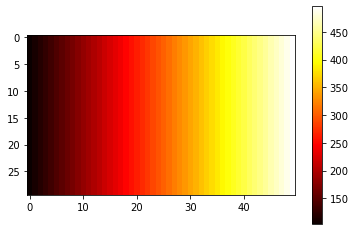

In [65]:
sim = myCFD.simulation(simulationParameters)

sim.solve('T')
sim.solve('C')

sim.display('C')
#sim.execute()

